In [1]:
import glob
import os
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import ciepy as cpy
import projectpy as ppy

%matplotlib inline
%load_ext rpy2.ipython

In [2]:
gene_info = pd.read_table(ppy.gencode_gene_info, index_col=0)

In [3]:
%%R 

library(qvalue)

From the qvalue manual:
    
*The argument stat must be such that the larger the value is the more deviated (i.e., "more extreme")
from the null hypothesis it is. Examples include an F-statistic or the absolute value of a t-statistic.
The argument stat0 should be calculated analogously on data that represents observations from
the null hypothesis distribution. The p-values are calculated as the proportion of values from stat0
that are greater than or equal to that from stat. If pool=TRUE is selected, then all of stat0 is used
in calculating the p-value for a given entry of stat. If pool=FALSE, then it is assumed that stat0
is a matrix, where stat0[i,] is used to calculate the p-value for stat[i]. The function empPvals
calculates "pooled" p-values faster than using a for-loop.*

I think I should be able to use the $-\log_{10}$ $p$-values is a statistic to derive empirical
$p$-values that I can then use with qvalue.

In [34]:
res_fns = glob.glob(os.path.join(cpy.root, 'output', 'run_eqtl_analysis', 'test_results', 
                                 '*', 'ENS*.tsv'))
min_fns = glob.glob(os.path.join(cpy.root, 'output', 'run_eqtl_analysis', 'test_results', 
                                 '*', 'minimum_pvalues.tsv'))
res_genes = set([os.path.splitext(os.path.split(x)[1])[0] for x in res_fns])
min_genes = set([x.split('/')[-2] for x in min_fns])
not_done = res_genes - min_genes
res_fns = [x for x in res_fns if os.path.splitext(os.path.split(x)[1])[0] not in not_done]

xgenes = set(gene_info[gene_info.chrom == 'chrX'].index)
res_fns = [x for x in res_fns if os.path.splitext(os.path.split(x)[1])[0] not in xgenes]
min_fns = [x for x in min_fns if x.split('/')[-2] not in xgenes]

In [35]:
pvals = []
for i, res_fn in enumerate(res_fns):
    assert os.path.splitext(os.path.split(res_fn)[1])[0] == min_fns[i].split('/')[-2]
    res = pd.read_table(res_fn)
    min_pvals = pd.read_table(min_fns[i], header=None, squeeze=True)
    p = sum(min_pvals > res.PVALUE.min()) / float(min_pvals.shape[0])
    pvals.append(p)
pvals = pd.Series(pvals)

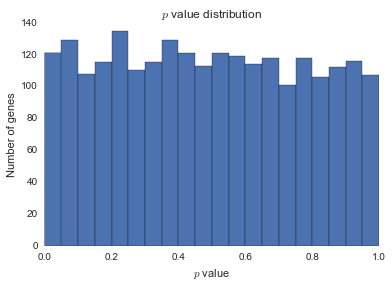

In [36]:
pvals.hist(bins=20)
plt.ylabel('Number of genes')
plt.xlabel('$p$ value')
plt.title('$p$ value distribution');

In [43]:
%%R -i pvals -o qvalues,pi0,lfdr,sig

qobj = qvalue(p=pvals, fdr.level=0.1)
qvalues <- qobj$qvalues
pi0 <- qobj$pi0
lfdr <- qobj$lfdr
sig <- qobj$significant

summary(qobj)


Call:
qvalue(p = pvals, fdr.level = 0.1)

pi0:	0.9540681	

Cumulative number of significant calls:

        <1e-04 <0.001 <0.01 <0.025 <0.05 <0.1   <1
p-value      0      0    24     50   118  249 2328
q-value      0      0     0      0     0    0 2328



`pi0` is the estimated proportion of true null hypotheses.

In [44]:
pi0

<FloatVector - Python:0x7f1fd04e28c0 / R:0x428ed78>
[0.954068]

In [39]:
qvalues = pd.Series(list(qvalues))

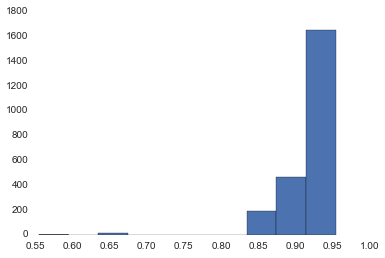

In [40]:
qvalues.hist()